In [119]:
import numpy as np
import torch
from sudoku import Sudoku
from matplotlib import pyplot as plt
from deep_sudoku.utils import sudoku_utils, data_utils

In [120]:
data_utils.split_data()
train_sudokus, val_sudokus, test_sudokus = data_utils.load_data()

In [121]:
def all_but_one_distribution():
    possible_numbers_of_moves_to_make = list(range(0,64))
    probabilities = [0]*64
    probabilities[63] = 1
    return possible_numbers_of_moves_to_make, probabilities

def n_moves_distribution(n):
    possible_numbers_of_moves_to_make = list(range(0,64))
    probabilities = [0]*64
    probabilities[n-1] = 1
    return possible_numbers_of_moves_to_make, probabilities

train_sudokus = data_utils.make_moves(train_sudokus, data_utils.uniform_possible_moves_distribution)
val_sudokus = data_utils.make_moves(val_sudokus, data_utils.uniform_possible_moves_distribution)
test_sudokus = data_utils.make_moves(test_sudokus, data_utils.uniform_possible_moves_distribution)


In [122]:
board = train_sudokus[0][0]
solved = train_sudokus[0][1]
rng = np.random.default_rng()

In [123]:
totals = np.zeros(65)
for sudoku in train_sudokus:
    totals[len(np.argwhere(sudoku[0]==0))] +=1


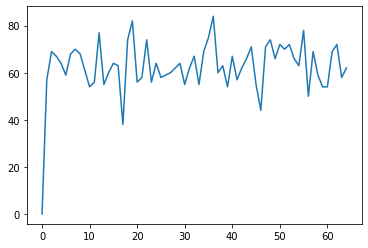

In [124]:
plt.plot(totals)

In [125]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class simpleNet(nn.Module):
    def __init__(self):
        super(simpleNet, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        
        self.convs = []
        for i in range(8):
            self.convs.append(nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1))
        self.convs = nn.ModuleList(self.convs)
        
        self.convlast = nn.Conv2d(in_channels = 64, out_channels = 9, kernel_size = 3, stride = 1, padding = 1)
    
    def forward(self, x):   
        x = self.conv0(x)
        x = nn.ReLU()(x)
        for conv in self.convs:
            x = conv(x)
            x = nn.ReLU()(x)
        x = self.convlast(x)
        return x
        
    

In [126]:
x_train, y_train = data_utils.fast_generate_batch(train_sudokus)
x_train = torch.tensor(x_train.reshape(-1,1,9,9).astype('float32'))
y_train = torch.tensor(y_train - 1).type(torch.LongTensor)

In [127]:
x_train, y_train = data_utils.generate_batch(train_sudokus)
x_train = torch.tensor(x_train.reshape(-1,1,9,9).astype('float32'))
y_train = torch.tensor(y_train - 1).type(torch.LongTensor)

In [128]:
x_val, y_val = data_utils.generate_batch(val_sudokus, augment = False)
x_val = torch.tensor(x_val.reshape(-1,1,9,9).astype('float32')).cuda()
y_val = torch.tensor(y_val - 1).type(torch.LongTensor).cuda()

In [129]:
from time import time
model = simpleNet()
model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True)
loss_fn = torch.nn.CrossEntropyLoss()

val_losses = []
losses = []

min_val_loss = 100
n_epochs = 100000
# # load the model checkpoint
# checkpoint = torch.load('./documentation/models/2/model.pth')
# # load model weights state_dict
# model.load_state_dict(checkpoint['model_state_dict'])
# print('Previously trained model weights state_dict loaded...')
# # load trained optimizer state_dict
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# print('Previously trained optimizer state_dict loaded...')
# start_epoch = checkpoint['epoch']
# # load the criterion
# loss = checkpoint['loss']
# print('Trained model loss function loaded...')
# min_val_loss = loss

for epoch in range(0, n_epochs):
    model.train()
    x_train, y_train = data_utils.fast_generate_batch(train_sudokus)
    x_train = torch.tensor(x_train.reshape(-1,1,9,9).astype('float32'))
    y_train = torch.tensor(y_train - 1).type(torch.LongTensor)
    x_train = x_train.cuda()
    y_train = y_train.cuda()
    
    y_pred = model(x_train)
    y_pred = y_pred.cuda()
    
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred_val = model(x_val)
        val_loss = loss_fn(y_pred_val, y_val)
        
    val_losses.append(val_loss.item())
    losses.append(loss.item())
    
    if (epoch % 1000) == 0:
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    }, './documentation/models/1/epoch%d_loss%.3f.pth' % (epoch,val_loss))
    if val_loss < min_val_loss:
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    }, './documentation/models/1/best.pth')
        min_val_loss = val_loss
        
    print(f'Epoch {epoch}, loss = {loss.item():.4f}, validation loss = {val_loss.item():.4f}.', end = "\r")
    
    
    

KeyboardInterrupt: 

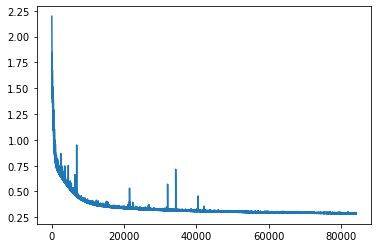

In [130]:
plt.plot(val_losses)

In [45]:
for i in range(1, 64):
    

torch.Size([2, 1, 9, 9])

In [51]:
x_val_np = x_val.cpu().numpy()

In [133]:
dictionary = {}
for i, val_sudoku in enumerate(val_sudokus):
    current_zeros = len(np.argwhere(val_sudoku[0] == 0))
    if current_zeros in dictionary.keys():
        dictionary[current_zeros] += [i]
    else:
        dictionary[current_zeros] = [i]

In [134]:
model.eval()

val_losses_i = []

for i in set(dictionary.keys()):
    
    x_val_i = x_val[dictionary[i]]
    y_val_i = y_val[dictionary[i]]
    
    with torch.no_grad():
        y_pred_val_i = model(x_val_i)
        val_loss_i = loss_fn(y_pred_val_i, y_val_i)

    val_losses_i.append(val_loss_i.item())

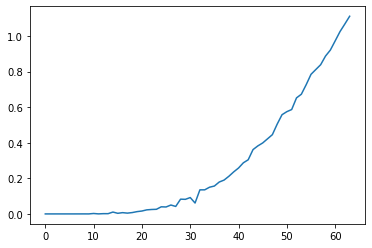

In [135]:
plt.plot(val_losses_i)

In [65]:
max_norm = 0
for p in model.parameters():
    param_norm = p.grad.data.norm(2)
    if param_norm > max_norm:
        max_norm = param_norm
max_norm

tensor(24.8296, device='cuda:0')

In [63]:
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, './documentation/models/2/model.pth')

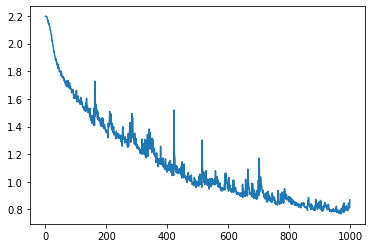

In [35]:
plt.plot(losses)

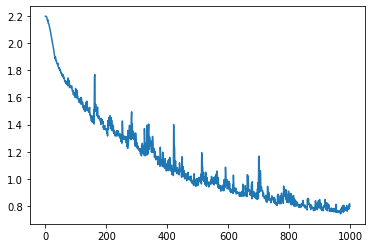

In [38]:
plt.plot(val_losses)

In [23]:
x_train, y_train = data_utils.fast_generate_batch(train_sudokus)


In [19]:
x_train, y_train = data_utils.fast_generate_batch(train_sudokus)


In [20]:
x_train[0]

array([[0, 0, 0, 7, 0, 0, 0, 0, 0],
       [0, 0, 0, 5, 0, 8, 0, 0, 9],
       [6, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 6, 1, 5],
       [0, 0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 9, 0, 0, 0, 4, 0, 0],
       [0, 5, 0, 0, 0, 0, 0, 0, 8],
       [0, 0, 0, 0, 6, 1, 0, 0, 0]], dtype=uint8)

In [21]:
x_train, y_train = data_utils.fast_generate_batch(train_sudokus)


In [35]:
x_train[0]

tensor([[[0., 0., 0., 7., 0., 9., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 6.],
         [0., 0., 0., 0., 0., 0., 1., 2., 8.],
         [0., 0., 0., 0., 0., 5., 0., 0., 0.],
         [0., 2., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 4., 1., 3., 0., 0.],
         [0., 0., 0., 2., 8., 0., 0., 0., 0.],
         [3., 0., 0., 0., 0., 0., 0., 9., 0.],
         [0., 0., 1., 0., 0., 0., 4., 0., 0.]]])

In [36]:
y_train[0]

tensor([[5, 7, 1, 6, 0, 8, 4, 2, 3],
        [3, 0, 2, 7, 4, 1, 8, 6, 5],
        [6, 4, 8, 3, 2, 5, 0, 1, 7],
        [0, 2, 5, 8, 1, 4, 7, 3, 6],
        [4, 1, 3, 2, 6, 7, 5, 0, 8],
        [7, 8, 6, 5, 3, 0, 2, 4, 1],
        [8, 3, 4, 1, 7, 2, 6, 5, 0],
        [2, 6, 7, 0, 5, 3, 1, 8, 4],
        [1, 5, 0, 4, 8, 6, 3, 7, 2]])

In [46]:
np.argwhere(y_pred[0,:,0,:].cpu() > -0.2)

tensor([[0, 2, 4, 6, 6, 6, 7, 8, 8, 8],
        [3, 5, 8, 4, 6, 8, 4, 3, 4, 8]])

In [41]:
y_pred[0].cpu().shape

torch.Size([9, 9, 9])

In [51]:
y_pred[0,:,0,8]

tensor([-0.9362, -4.6014, -0.5402, -0.2921,  0.2304, -0.3378, -0.1828, -0.4231,
         0.0343], device='cuda:0', grad_fn=<SelectBackward>)

In [52]:
torch.save(model, "documentation/models/1/state_dict.pt")

PicklingError: Can't pickle <class '__main__.simpleNet'>: it's not the same object as __main__.simpleNet

In [82]:
%%timeit
for i in range(4062):
    sudoku_utils.make_random_moves(board, solved, 20, 0)

197 ms ± 2.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
tots = np.zeros(100)
for i, sudoku in enumerate(new_train_sudokus):
    moves_made = len(np.argwhere(sudoku[0] != 0)) - 17
    tots[moves_made] += 1

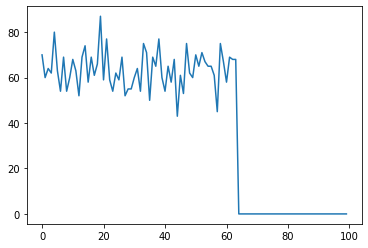

In [25]:
plt.plot(tots)

In [36]:
def all_but_one_distribution():
    possible_numbers_of_moves_to_make = list(range(0,64))
    probabilities = [0]*64
    probabilities[63] = 1
    return possible_numbers_of_moves_to_make, probabilities

In [40]:
new_train_sudokus[0][0]

array([[6, 9, 3, 7, 8, 4, 5, 1, 2],
       [4, 8, 7, 5, 1, 2, 9, 3, 6],
       [1, 2, 5, 9, 6, 3, 8, 7, 4],
       [9, 3, 2, 6, 5, 1, 4, 8, 7],
       [5, 6, 8, 2, 4, 7, 3, 9, 1],
       [0, 4, 1, 3, 9, 8, 6, 2, 5],
       [3, 1, 9, 4, 7, 5, 2, 6, 8],
       [8, 5, 6, 1, 2, 9, 7, 4, 3],
       [2, 7, 4, 8, 3, 6, 1, 5, 9]], dtype=uint8)

In [107]:
x_train[0,0, 6, 7]

tensor(0., device='cuda:0')

In [98]:
y = model(x_train[0].reshape(-1, 1, 9, 9))

In [119]:
a = y[0,:].cpu().detach().numpy()

In [126]:
m = torch.nn.Softmax()
m(y[0,:,6,7])


<ipython-input-126-dff5b86ba716>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  m(y[0,:,6,7])


tensor([3.8428e-05, 2.2237e-01, 4.7696e-03, 1.7718e-02, 7.1976e-02, 4.3815e-01,
        2.2063e-01, 2.3932e-02, 4.2340e-04], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [116]:
y_train[0]

tensor([[0, 2, 7, 6, 3, 5, 4, 8, 1],
        [5, 4, 3, 8, 1, 2, 0, 6, 7],
        [6, 1, 8, 7, 0, 4, 5, 3, 2],
        [2, 7, 4, 0, 8, 6, 3, 1, 5],
        [8, 6, 1, 5, 4, 3, 2, 7, 0],
        [3, 5, 0, 1, 2, 7, 8, 4, 6],
        [4, 0, 6, 2, 7, 8, 1, 5, 3],
        [7, 8, 2, 3, 5, 1, 6, 0, 4],
        [1, 3, 5, 4, 6, 0, 7, 2, 8]], device='cuda:0')

In [79]:
y_train[0]

tensor([[8, 2, 1, 0, 4, 3, 5, 6, 7],
        [3, 5, 4, 2, 6, 7, 0, 1, 8],
        [7, 0, 6, 8, 5, 1, 3, 4, 2],
        [1, 8, 0, 5, 7, 2, 4, 3, 6],
        [6, 4, 3, 1, 8, 0, 2, 7, 5],
        [2, 7, 5, 4, 3, 6, 8, 0, 1],
        [4, 3, 2, 7, 1, 8, 6, 5, 0],
        [0, 6, 7, 3, 2, 5, 1, 8, 4],
        [5, 1, 8, 6, 0, 4, 7, 2, 3]], device='cuda:0')

In [83]:
y[0,:,0,0]

tensor([-61.6282, -71.7021, -58.5719, -95.3305, -73.5535, -46.4773,  -1.0167,
         21.3101,  26.0130], device='cuda:0', grad_fn=<SelectBackward>)

In [82]:
x_train[0,0,0,0]

tensor(9., device='cuda:0')

In [84]:
x = x_train[0]